Run changepoint anomaly (ruptures)

Run FB Prophet

Test window for predictions will be last week (14 days)

Train window will be from last changepoint to 21 days ago.
    if the last changepoint is less than a week prior to 7days ago, ignore 
    changepoint and start training from 7 days prior to the test window

In [30]:
import os
import pandas as pd
import prophet
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import plotly.express as px
from prophet import Prophet
import ruptures as rpt
from ruptures.utils import pairwise
from itertools import cycle
# import seaborn as sns

mpl.rcParams['figure.figsize'] = (20, 16)
mpl.rcParams['axes.grid'] = False

In [31]:
# Load and rename columns etl.py

def load_df():
    #Need help here
    pass

def rename_columns_for_prophet(df_inp, old_column_list):

    #Need help here too, a simple renaming as written below could work as long
    #we ensure that input df comes with only 2 columns, first being datetime
    #and the next being counts or whatever the anomaly is supposed to run on
    df = df_inp[old_column_list]
    new_column_list = ['ds','y']
    df = df.rename(columns=dict(zip(old_column_list, new_column_list))) 
    df.ds = pd.to_datetime(df.ds)
    return df 

def reindex_df(df_inp):
    '''
    '''
    start_date = df_inp.ds.iloc[0] 
    end_date = df_inp.ds.iloc[-1]
    idx = pd.date_range(start_date, end_date)

    df = df_inp.set_index('ds')#,inplace=True)
    df = df.reindex(idx)
    df['y']= df['y'].interpolate(method='linear')
    df = df.rename_axis('ds').reset_index()
    return df



In [32]:
df_raw = pd.read_csv('../data/tforce_driver_scored.csv')
df = rename_columns_for_prophet(df_raw, ['startdate','ndriver_distinct'])
df = reindex_df(df)


,ds,y
0,2021-11-04,5950.0
1,2021-11-05,5950.0
2,2021-11-06,5954.0
3,2021-11-07,5954.0
4,2021-11-08,5954.0
...,...,...
392,2022-12-01,4907.0
393,2022-12-02,3603.5
394,2022-12-03,2300.0
395,2022-12-04,5069.0


In [66]:
df[0]

KeyError: 0

In [61]:
class AnomalyDetector:
    def __init__(self, test_window=14, train_window=21, beta=0.1, 
    ruptures_changepnt_penalty=10, prophet_interval_width=0.95, 
    prophet_changepnt_prior = 0.15, weekly_seasonality= False,
    color_cycle = ["#4286f4", "#f44174"]):
        '''
        Args
        ---
        changepoint_penalty: float
        Higher the value, more conservative the segmentation, must be >0
        '''
        self.df = df
        self.test_window = test_window
        self.train_window = train_window
        self.beta = beta
        self.ruptures_changepnt_penalty = ruptures_changepnt_penalty
        self.prophet_interval_width = prophet_interval_width
        self.prophet_changepnt_prior = prophet_changepnt_prior
        self.weekly_seasonality = weekly_seasonality
        self.color_cycle = color_cycle
        self.P = P

    def apply(self, df):



    def apply_changepnt_detection(self,changepnt_model="rbf"):
            
        '''
        Apply changepoint detection ala ruptures package and generate breakpoint indices
        Args
        ---
        changepoint_model: str
            Pelt segment model, ["l1", "l2", "rbf"] 
            https://centre-borelli.github.io/ruptures-docs/code-reference/detection/pelt-reference/

        
        Returns
        ---
        breakpoints: list
            List of breakpoint indices
        '''
        signal = self.df['y'].to_numpy()
        algo = rpt.Pelt(model=changepnt_model).fit(signal)
        result = algo.predict(pen=self.ruptures_changepnt_penalty)
        breakpoints = [0] + sorted(result)
        self.changepnts = breakpoints
        return self

    def plot_changepoints(self): 
        color_cycle = cycle(self.color_cycle)
        fig, ax = plt.subplots(1,1,figsize=(16,8))
        ax.plot(self.df['ds'],self.df['y'], '-o', markersize=2, linewidth=1)
        for (start, end), col in zip(pairwise(self.changepnts), color_cycle):
            ax.axvspan(self.df.iloc[max(0,start-1)]['ds'], self.df.iloc[end-1]['ds'], facecolor=col,alpha=0.2)
        plt.show()

    def prophet_fit(self):

        #instantiate the prophet model
        prophet_model = Prophet(interval_width=self.prophet_interval_width,
            yearly_seasonality=False,
            weekly_seasonality=self.weekly_seasonality,
            changepoint_prior_scale=self.prophet_changepnt_prior
            )
        
        #segment time frames
        # Test/Forecast window
        end_index = self.df.index[-1]
        test_start_index = end_index - self.test_window + 1 
        print(f'TEST start index is {test_start_index}')
        print(f'TEST END index is {end_index}') #the test end index is setup to be the last index of df
        
        # Train window, starts at the last changepoint unless the train window goes further back
        if test_start_index - self.changepnts[-2] < self.train_window:
            train_start_index = test_start_index - self.train_window
        else:
            train_start_index = self.changepnts[-2]
        print(f'TRAIN start index is {train_start_index}')

        train_end_index = test_start_index - 1
        print(f'TRAIN end index is {train_end_index}')
        baseline_ts = self.df['ds'][train_start_index:train_end_index]
        baseline_y = self.df['y'][train_start_index:train_end_index]
        print('TRAIN from {} to {}'.format(self.df['ds'][train_start_index], self.df['ds'][train_end_index]))
        print('PREDICT from {} to {}'.format(self.df['ds'][test_start_index], self.df['ds'][end_index]))

        # fit the model
        prophet_model.fit(pd.DataFrame({'ds': baseline_ts.values,
                                        'y': baseline_y.values}))#,  algorithm = 'Newton')
        
        future = prophet_model.make_future_dataframe(periods=self.test_window)
        # make prediction
        forecast = prophet_model.predict(future)
        self.forecast = forecast
        self.model = prophet_model
        return self

    def get_outliers(self):
        """
        Combine the actual values and forecast in a data frame and identify the outliers
        Args
        ----
        df : pandas DataFrame
            The daily time-series data set contains ds column for
            dates (datetime types such as datetime64[ns]) and y column for numerical values
        forecast : pandas DataFrame
            The predicted result in a dataframe which was previously generated by
            Prophet's model.predict(future)
        beta : float
            amplifying factor for setting lower and upperbounds for anomalies
        test_window : int
            Number of days for Prophet to make predictions for
        Returns
        -------
        outliers : a list of (datetime, int, int) triple
            A list of outliers, the date, the value, and penalty for each
        df_pred : pandas DataFrame
            The data set contains actual and predictions for the forecast time frame
        P : int
            Net penalty value of all the outliers detected
        """
        df_pred = self.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(self.test_window)
        df_pred.index = df_pred['ds'].dt.to_pydatetime()
        df_pred.columns = ['ds', 'preds', 'lower_y', 'upper_y']
        end_index = self.df.index[-1]

        test_start_index = end_index - self.test_window 
        df_pred['actual'] = self.df['y'][test_start_index: end_index].values

        # construct a list of outliers
        outlier_index = list()
        outliers = list()
        penalty = list()
        P = 0 # net penalty
        for i in range(df_pred.shape[0]):
            actual_value = df_pred['actual'][i]
            pred_value   = df_pred['preds'][i]
            lower_bound  = (1-self.beta)*df_pred['lower_y'][i]
            upper_bound  = (1+self.beta)*df_pred['upper_y'][i]
            if actual_value < lower_bound:
                outlier_index += [i]
                p = (pred_value - actual_value)/pred_value
                penalty.append(p)
                outliers.append((df_pred.index[i], actual_value, p))
                
            elif actual_value > upper_bound:
                outlier_index += [i]
                p = (actual_value - pred_value)/pred_value
                penalty.append(p)
                outliers.append((df_pred.index[i], actual_value, p))            

                # print out the evaluation for each outlier
                print('=====')
                print('actual value {} fall outside of the prediction interval'.format(actual_value))
                print('interval: {} to {}'.format(lower_bound, upper_bound))
                print('Date: {}'.format(str(df_pred.index[i])[:10]))

        P = sum(penalty)
        print('Net Penalty for the prediction interval of last {} days is {}'.format(self.test_window, P))
        for outlier in outliers:
            print(outlier)
        
        self.outliers = outliers #list
        self.P = P  #scalar

        return self



    def prophet_plot(self):#df, forecast, prophet_model, changepoints_list, outliers=list()):
        """
        Plot the actual, predictions, and anomalous values
        Args
        ----
        df : pandas DataFrame
            The daily time-series data set contains ds column for
            dates (datetime types such as datetime64[ns]) and y column for numerical values

        outliers : a list of (datetime, int) tuple
            The outliers we want to highlight on the plot.
        """
        # generate the plot
        fig = self.model.plot(self.forecast)
        
        # retrieve the subplot in the generated Prophets matplotlib figure
        ax = fig.get_axes()[0]

        #plot actual values
        x_pydatetime = self.df['ds'].dt.to_pydatetime()
        ax.plot(x_pydatetime,
            self.df.y,
            color='orange', label='Actual')

        # plot each outlier in red, uncomment the second line to annotate date (makes it super crowded though)
        for outlier in self.outliers:
            ax.scatter(outlier[0], outlier[1], s = 16, marker='x', color='red', label='Anomaly')
            # ax.text(outlier[0], outlier[1], str(outlier[0])[:10], color='red')


        # re-organize the legend
        patch1 = mpatches.Patch(color='red', label='Anomaly')
        patch2 = mpatches.Patch(color='orange', label='Actual')
        patch3 = mpatches.Patch(color='skyblue', label='Prediction interval')
        plt.legend(handles=[patch1, 
                            patch2, 
                            patch3, 
                            ])
        
        #plot the changepoints

        color_cycle = cycle(self.color_cycle)
        for (start, end), col in zip(pairwise(self.changepnts), color_cycle):
            ax.axvspan(self.df.iloc[max(0,start-1)]['ds'], self.df.iloc[end-1]['ds'], facecolor=col,alpha=0.2)

        plt.show()
        


13:11:31 - cmdstanpy - INFO - Chain [1] start processing
13:11:31 - cmdstanpy - INFO - Chain [1] done processing


TEST start index is 383
TEST END index is 396
TRAIN start index is 362
TRAIN end index is 382
TRAIN from 2022-11-01 00:00:00 to 2022-11-21 00:00:00
PREDICT from 2022-11-22 00:00:00 to 2022-12-05 00:00:00
Net Penalty for the prediction interval of last 14 days is 0.9177641298107937
(Timestamp('2022-12-02 00:00:00'), 3603.5, 0.3396059139868984)
(Timestamp('2022-12-03 00:00:00'), 2300.0, 0.5781582158238954)


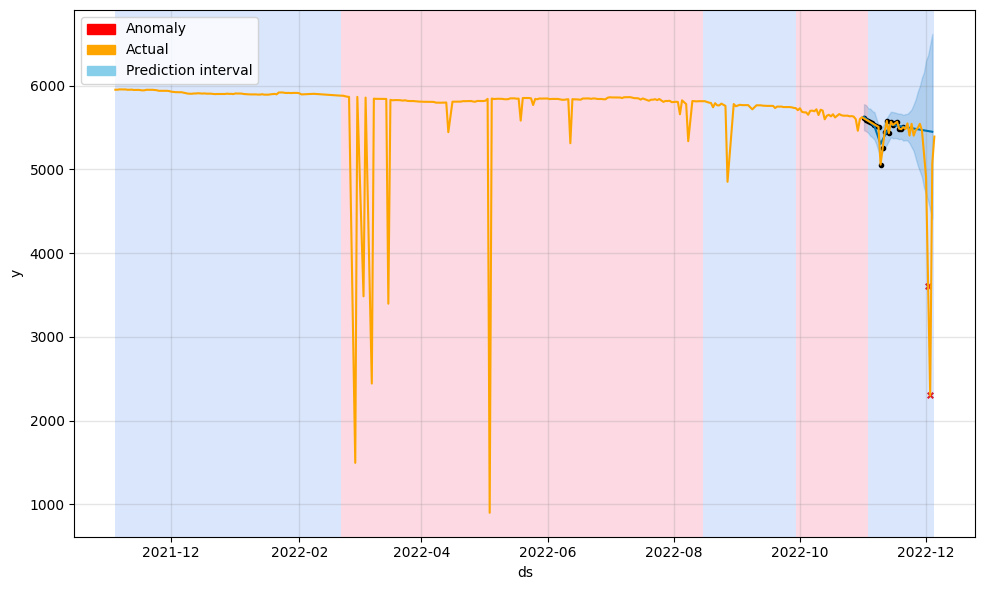

In [62]:
foo = AnomalyDetector(df)
foo.apply_changepnt_detection().prophet_fit().get_outliers().prophet_plot()



In [64]:
foo.P

NameError: name 'foo' is not defined

In [63]:
##OLD CODE

0.9177641298107937

In [7]:
# 1) Run changepoint anomaly

def apply_changepnt_detection(df,changepoint_model="rbf", changepoint_penalty=10):
    '''
    Apply changepoint detection ala ruptures package and generate breakpoint indices
    Args
    ---
    changepoint_model: str
        Pelt segment model, ["l1", "l2", "rbf"] 
        https://centre-borelli.github.io/ruptures-docs/code-reference/detection/pelt-reference/
    changepoint_penalty: float
        Higher the value, more conservative the segmentation, must be >0
    
    Returns
    ---
    breakpoints: list
        List of breakpoint indices
    '''
    signal = df['y'].to_numpy()
    algo = rpt.Pelt(model=changepoint_model).fit(signal)
    result = algo.predict(pen=changepoint_penalty)
    breakpoints = [0] + sorted(result)
    return breakpoints

#Plot changepoints
def plot_changepoints(df_inp, changepoints=list(),COLOR_CYCLE = ["#4286f4", "#f44174"]):    
    color_cycle = cycle(COLOR_CYCLE)
    fig, ax = plt.subplots(1,1,figsize=(16,8))
    ax.plot(df['ds'],df['y'], '-o', markersize=2, linewidth=1)
    for (start, end), col in zip(pairwise(changepoints), color_cycle):
        ax.axvspan(df.iloc[max(0,start-1)]['ds'], df.iloc[end-1]['ds'], facecolor=col,alpha=0.2)
    plt.show()

In [8]:
# 2) Fit prophet 

def prophet_fit(df, prophet_model, changepoints_list, test_window = 7, train_window = 14):
    """
    Fit the model to the time-series data and generate forecast for specified time frames
    Args
    ----
    df : pandas DataFrame
        The daily time-series data set contains ds column for
        dates and y column for numerical values
    prophet_model : Prophet model
        Prophet model with configured parameters
    changepoints_list : list
        List of breakpoint indices as evaluated by ruptures package
    test_window : int
        Number of days for Prophet to make predictions for
    train_window: int
        Min number of days leading upto the start of the test window

    Returns
    -------
    forecast : pandas DataFrame
        The predicted result in a format of dataframe
    prophet_model : Prophet model
        Trained model
    """

    # segment the time frames
    end_index = df.index[-1]
    test_start_index = end_index - test_window + 1 
    print(f'TEST start index is {test_start_index}')
    print(f'TEST END index is {end_index}') #the test end index is setup to be the last index of df
    if test_start_index - changepoints_list[-2] < train_window:
        train_start_index = test_start_index - train_window
    else:
        train_start_index = changepoints_list[-2]
    print(f'TRAIN start index is {train_start_index}')

    train_end_index = test_start_index - 1
    print(f'TRAIN end index is {train_end_index}')
    baseline_ts = df['ds'][train_start_index:train_end_index]
    baseline_y = df['y'][train_start_index:train_end_index]
    
    print('TRAIN from {} to {}'.format(df['ds'][train_start_index], df['ds'][train_end_index]))
    print('PREDICT from {} to {}'.format(df['ds'][test_start_index], df['ds'][end_index]))

    # fit the model
    prophet_model.fit(pd.DataFrame({'ds': baseline_ts.values,
                                    'y': baseline_y.values}),  algorithm = 'Newton')
    
    future = prophet_model.make_future_dataframe(periods=test_window)
    # make prediction
    forecast = prophet_model.predict(future)
    return forecast, prophet_model


def get_outliers(df, forecast, beta=0.1, test_window=7):
    """
    Combine the actual values and forecast in a data frame and identify the outliers
    Args
    ----
    df : pandas DataFrame
        The daily time-series data set contains ds column for
        dates (datetime types such as datetime64[ns]) and y column for numerical values
    forecast : pandas DataFrame
        The predicted result in a dataframe which was previously generated by
        Prophet's model.predict(future)
    test_window : int
        Number of days for Prophet to make predictions for
    Returns
    -------
    outliers : a list of (datetime, int, int) triple
        A list of outliers, the date, the value, and penalty for each
    df_pred : pandas DataFrame
        The data set contains actual and predictions for the forecast time frame
    P : int
        Net penalty value of all the outliers detected
    """
    df_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test_window)
    df_pred.index = df_pred['ds'].dt.to_pydatetime()
    df_pred.columns = ['ds', 'preds', 'lower_y', 'upper_y']
    end_index = df.index[-1]

    test_start_index = end_index - test_window 
    df_pred['actual'] = df['y'][test_start_index: end_index].values

    # construct a list of outliers
    outlier_index = list()
    outliers = list()
    penalty = list()
    P = 0 # net penalty
    for i in range(df_pred.shape[0]):
        actual_value = df_pred['actual'][i]
        pred_value   = df_pred['preds'][i]
        lower_bound  = (1-beta)*df_pred['lower_y'][i]
        upper_bound  = (1+beta)*df_pred['upper_y'][i]
        if actual_value < lower_bound:
            outlier_index += [i]
            p = (pred_value - actual_value)/pred_value
            penalty.append(p)
            outliers.append((df_pred.index[i], actual_value, p))
            
        elif actual_value > upper_bound:
            outlier_index += [i]
            p = (actual_value - pred_value)/pred_value
            penalty.append(p)
            outliers.append((df_pred.index[i], actual_value, p))            

            # print out the evaluation for each outlier
            print('=====')
            print('actual value {} fall outside of the prediction interval'.format(actual_value))
            print('interval: {} to {}'.format(df_pred['lower_y'][i], df_pred['upper_y'][i]))
            print('Date: {}'.format(str(df_pred.index[i])[:10]))

    P = sum(penalty)
    print('Net Penalty for the prediction interval of last {} days is {}'.format(test_window, P))
    for outlier in outliers:
        print(outlier)
    return outliers, df_pred, P


def prophet_plot(df, prophet_model, changepoints_list, test_window = 7, train_window = 14, outliers=list()):
    """
    Plot the actual, predictions, and anomalous values
    Args
    ----
    df : pandas DataFrame
        The daily time-series data set contains ds column for
        dates (datetime types such as datetime64[ns]) and y column for numerical values

    outliers : a list of (datetime, int) tuple
        The outliers we want to highlight on the plot.
    """
    # generate the plot
    fig = prophet_model.plot(forecast)
    
    # retrieve the subplot in the generated Prophets matplotlib figure
    ax = fig.get_axes()[0]

    #plot actual values
    x_pydatetime = df['ds'].dt.to_pydatetime()
    ax.plot(x_pydatetime,
        df.y,
        color='orange', label='Actual')

    # plot each outlier in red, uncomment the second line to annotate date (makes it super crowded though)
    for outlier in outliers:
        ax.scatter(outlier[0], outlier[1], s = 16, marker='x', color='red', label='Anomaly')
        # ax.text(outlier[0], outlier[1], str(outlier[0])[:10], color='red')


    # re-organize the legend
    patch1 = mpatches.Patch(color='red', label='Anomaly')
    patch2 = mpatches.Patch(color='orange', label='Actual')
    patch3 = mpatches.Patch(color='skyblue', label='Prediction interval')
    plt.legend(handles=[patch1, 
                        patch2, 
                        patch3, 
                        ])
    
    #plot the changepoints
    COLOR_CYCLE = ["#4286f4", "#f44174"]
    color_cycle = cycle(COLOR_CYCLE)
    for (start, end), col in zip(pairwise(chngpnts), color_cycle):
        ax.axvspan(df.iloc[max(0,start-1)]['ds'], df.iloc[end-1]['ds'], facecolor=col,alpha=0.2)

    plt.show()

10:03:03 - cmdstanpy - INFO - Chain [1] start processing


TEST start index is 367
TEST END index is 396
TRAIN start index is 325
TRAIN end index is 366
TRAIN from 2022-09-25 00:00:00 to 2022-11-05 00:00:00
PREDICT from 2022-11-06 00:00:00 to 2022-12-05 00:00:00


10:03:04 - cmdstanpy - INFO - Chain [1] done processing


Net Penalty for the prediction interval of last 30 days is 1.0907992029899247
(Timestamp('2022-11-09 00:00:00'), 5055.0, 0.08745193380734007)
(Timestamp('2022-12-01 00:00:00'), 4907.0, 0.09439661509926034)
(Timestamp('2022-12-02 00:00:00'), 3603.5, 0.33428649788414755)
(Timestamp('2022-12-03 00:00:00'), 2300.0, 0.5746641561991768)


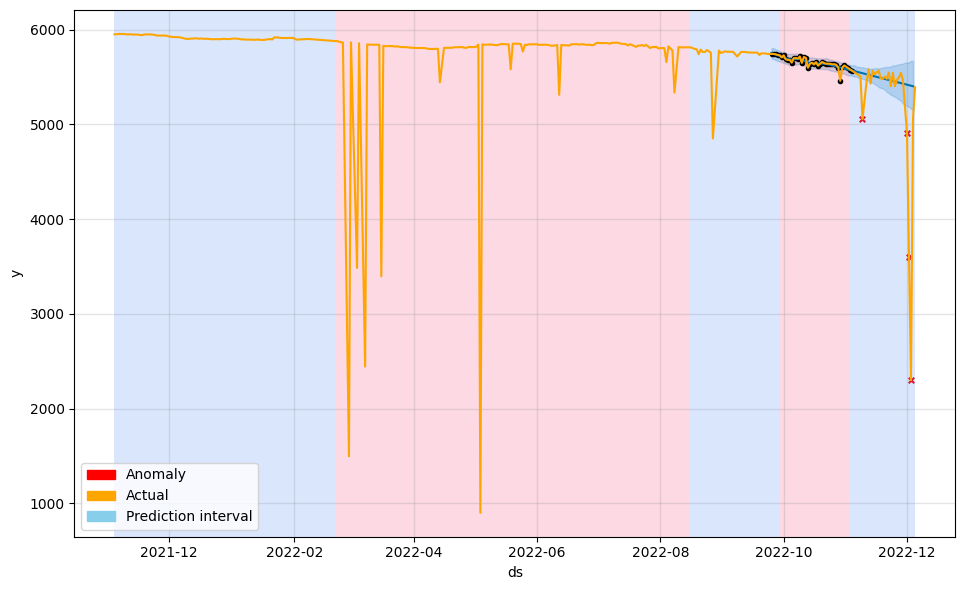

In [9]:
alpha=0.95
m = Prophet(interval_width=alpha,
            yearly_seasonality=False,
            weekly_seasonality=False,
            changepoint_prior_scale=0.15
            )
# model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.3)

chngpnts = apply_changepnt_detection(df, changepoint_penalty=10)
forecast, model = prophet_fit(df, m, chngpnts, train_window = 42, test_window = 30)
outliers, df_pred, penalty = get_outliers(df, forecast, beta=0.05, test_window=30)

prophet_plot(df, model, chngpnts, outliers=outliers)

In [10]:
# TEST on another df

df_raw = pd.read_pickle('/content/drive/MyDrive/data/anomaly/test_timeseries_tforcefcw.pkl')
df = rename_columns_for_prophet(df_raw)
df = reindex_df(df)
df

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data/anomaly/test_timeseries_tforcefcw.pkl'

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1k_33epk/x4whc719.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1k_33epk/49ldcm3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39154', 'data', 'file=/tmp/tmp1k_33epk/x4whc719.json', 'init=/tmp/tmp1k_33epk/49ldcm3v.json', 'output', 'file=/tmp/tmp1k_33epk/prophet_modelljhmpusx/prophet_model-20221216135910.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:59:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


TEST start index is 170
TEST END index is 183
TRAIN start index is 80
TRAIN end index is 169
TRAIN from 2021-11-17 00:00:00+00:00 to 2022-02-14 00:00:00+00:00
PREDICT from 2022-02-15 00:00:00+00:00 to 2022-02-28 00:00:00+00:00


13:59:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Net Penalty for the prediction interval of last 14 days is 5.111761930084952
(Timestamp('2022-02-15 00:00:00'), 23.333333333333336, 0.9081188564820104)
(Timestamp('2022-02-16 00:00:00'), 34.66666666666667, 0.8841522525394019)
(Timestamp('2022-02-17 00:00:00'), 46.0, 0.8158394292465143)
(Timestamp('2022-02-18 00:00:00'), 57.333333333333336, 0.7065808248193314)
(Timestamp('2022-02-22 00:00:00'), 102.66666666666667, 0.5938430118248688)
(Timestamp('2022-02-23 00:00:00'), 114.0, 0.6175367938363293)
(Timestamp('2022-02-24 00:00:00'), 103.0, 0.5856907613364957)


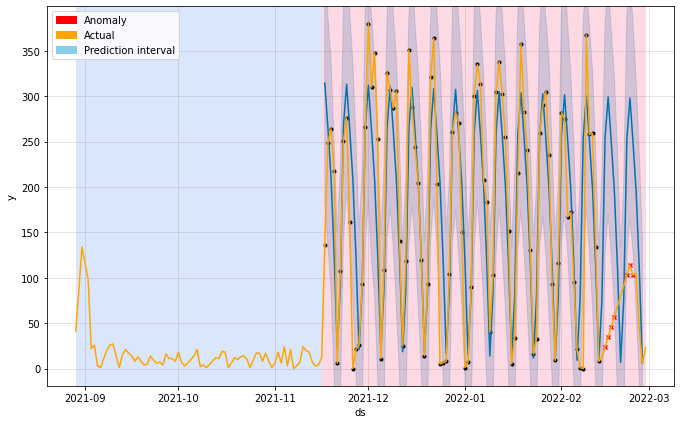

In [58]:
alpha=0.95
m = Prophet(interval_width=alpha,
            # yearly_seasonality=False,
            # weekly_seasonality=False,
            changepoint_prior_scale=0.15
            )
# model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.3)

chngpnts = apply_changepnt_detection(df, changepoint_penalty=10)
forecast, model = prophet_fit(df, m, chngpnts, train_window = 21, test_window = 14)
outliers, df_pred, penalty = get_outliers(df, forecast, beta=0.05, test_window=14)

prophet_plot(df, model, chngpnts, outliers=outliers)